In [1]:
# core
import sys, os, re, argparse, csv
import numpy as np
import pandas as pd
from glob import glob
from scipy import spatial
from tqdm import tqdm, tqdm_notebook
from datetime import datetime
# plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
%matplotlib inline
# Comment the next line out if not using a retina display
%config InlineBackend.figure_format ='retina'
from IPython.display import Image
from ipywidgets import *
# image recognition
import cv2
import imutils
import PIL.Image
from pytesseract import image_to_string
import pytesseract
import skimage.measure
from skimage import io, data
from skimage.util import img_as_float, img_as_ubyte
from skimage.segmentation import morphological_geodesic_active_contour, inverse_gaussian_gradient

In [86]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_x_axes.join(target, ax)
        if sharey:
            target._shared_y_axes.join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1,:].flat:
            ax.xaxis.set_tick_params(which='both', labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:,1:].flat:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)

In [4]:
cells = cv2.cvtColor(cv2.imread("../Data/sandbox_data/CellLibrary.jpg"), cv2.COLOR_RGB2BGR)
dragonfly = cv2.cvtColor(cv2.imread("../Data/sandbox_data/dragonflywing.jpg"), cv2.COLOR_RGB2BGR)
hammerhead = cv2.cvtColor(cv2.imread("../Data/sandbox_data/hammerhead.png"), cv2.COLOR_RGB2BGR)
maize = cv2.cvtColor(cv2.imread("../Data/sandbox_data/Maize-Ds-GFP.png"), cv2.COLOR_RGB2BGR)
neurons = cv2.cvtColor(cv2.imread("../Data/sandbox_data/neurons_CIL6843_512r.jpg"), cv2.COLOR_RGB2BGR)
sperg = cv2.cvtColor(cv2.imread("../Data/sandbox_data/C_spergularina_step2.tif"), cv2.COLOR_RGB2BGR)
thresher = cv2.cvtColor(cv2.imread("../Data/sandbox_data/Thresher1.DorsalNub.LPost.DownRight.jpg"), cv2.COLOR_RGB2BGR)
yucca = cv2.cvtColor(cv2.imread("../Data/sandbox_data/2.2_10x.jpg"), cv2.COLOR_RGB2BGR)

images = [cells, dragonfly, hammerhead, maize, neurons, sperg, thresher, yucca]

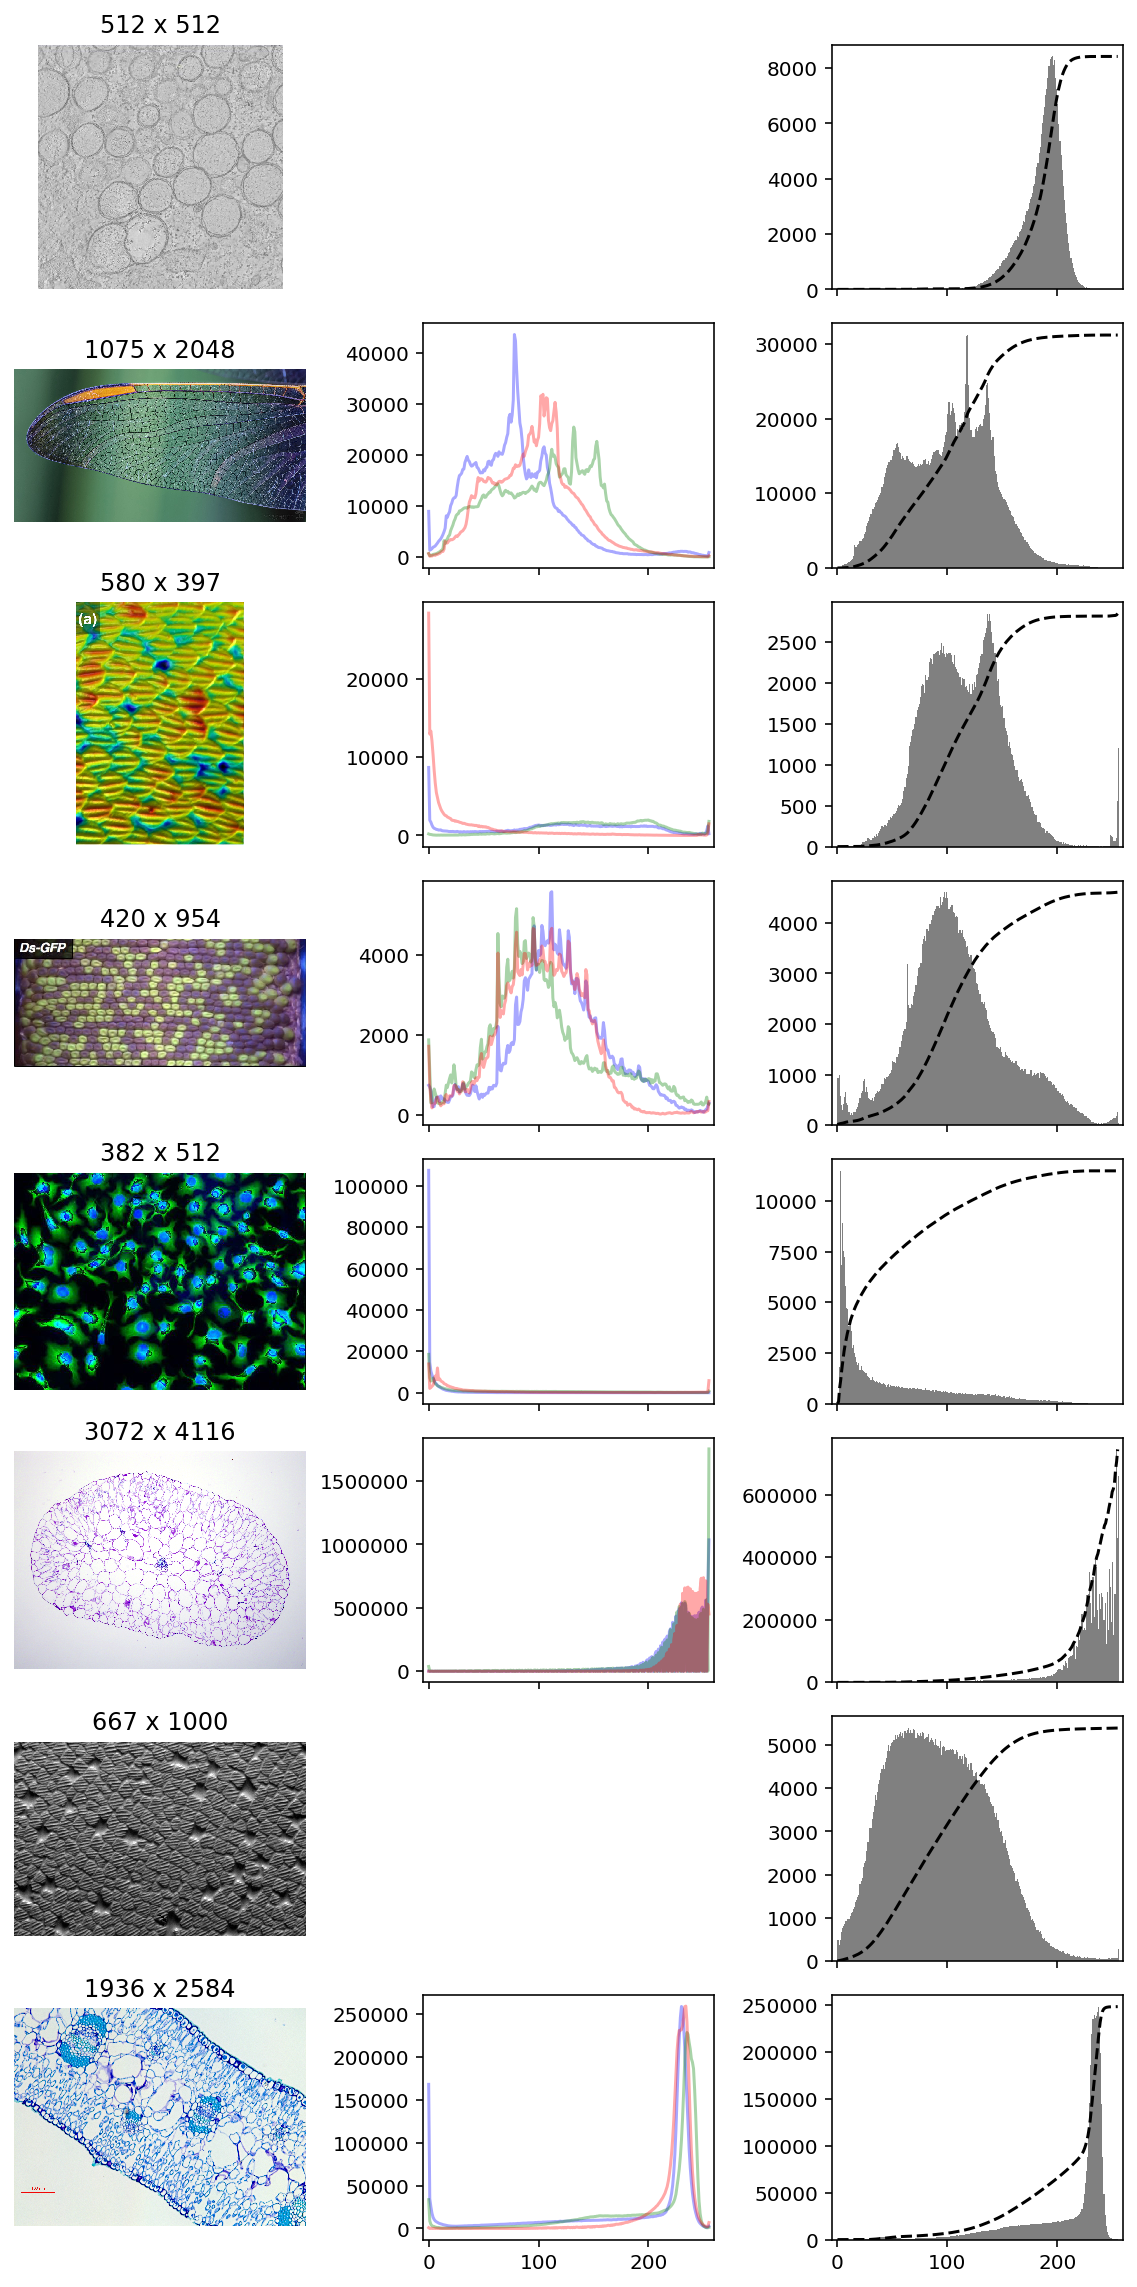

In [190]:
fig, ax = plt.subplots(nrows=8, ncols=3, figsize=(8, 16))
set_share_axes(ax[:,1:], sharex=True)

for i, img in enumerate(images):
    ax[i,0].imshow(img, vmin=0, vmax=255, cmap="gray")
    ax[i,0].axis('off')
    ax[i,0].set_title("{} x {}".format(img.shape[0], img.shape[1]))
    
    color = ('b','g','r')
    if i in [0, 6]:
        ax[i, 1].axis('off')
    else:
        for c, col in enumerate(color):
            histr = cv2.calcHist(images=[img], channels=[c], mask=None, histSize=[256], ranges=[0,256])
            ax[i,1].plot(histr, color = col, alpha = 0.34)
            ax[i,1].set_xlim(-5, 260)
#     ax[i,1].set_yticklabels(['{:.1E}'.format(item) for item in ax[i,1].get_yticks()])

    """Contrast histogram"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist, bins = np.histogram(a = gray, bins=256, range=[0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf*hist.max()/cdf.max()

    ax[i, 2].plot(cdf_normalized, color = 'black', linestyle="--")
    ax[i, 2].hist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).flatten(), 256, [0,256], color = 'grey')
    ax[i, 2].set_xlim([-5,260])
#     ax[i, 2].set_yticklabels(['{:.1}'.format(item) for item in ax[i, 2].get_yticks()])

    
#     """Contrast normalization"""
#     gridsize = max(8, int(0.01*max(img.shape)))
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(gridsize, gridsize))
#     hequalized = clahe.apply(gray)
    
#     hist, bins = np.histogram(a = hequalized.flatten(), bins=256, range=[0,256])
#     cdf = hist.cumsum()
#     cdf_normalized = cdf * hist.max()/ cdf.max()

#     ax[i, 3].plot(cdf_normalized, color = 'black', linestyle="--")
#     ax[i, 3].hist(hequalized.flatten(), 256, [0,256], color = 'grey')
#     ax[i, 3].set_xlim([0,256])

plt.tight_layout(h_pad=0.1)

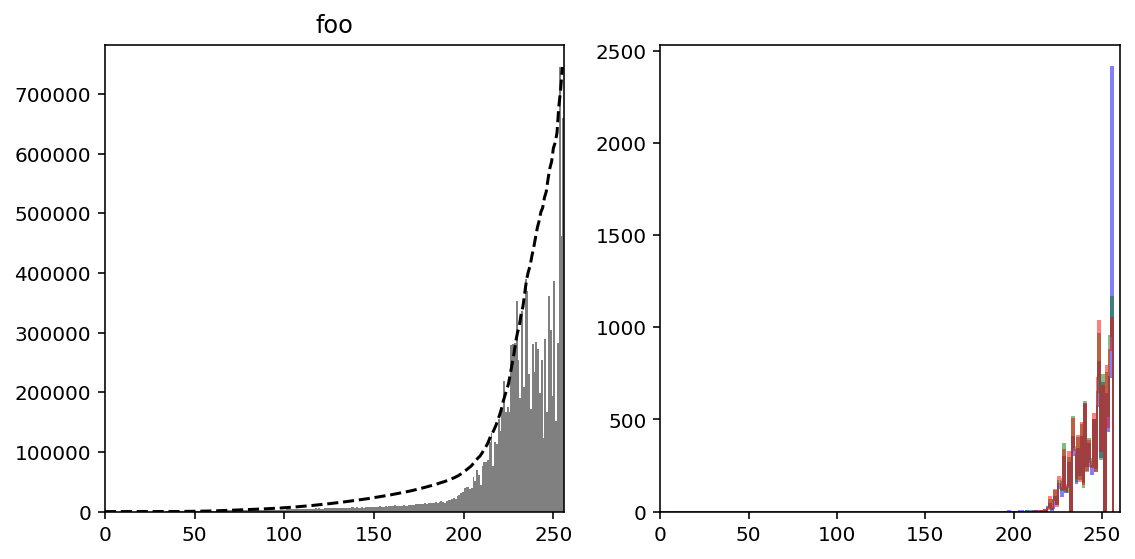

In [178]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
hist, bins = np.histogram(a = cv2.cvtColor(sperg, cv2.COLOR_BGR2GRAY).flatten(), bins=256, range=[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

ax[0].plot(cdf_normalized, color = 'black', linestyle="--")
ax[0].hist(cv2.cvtColor(sperg, cv2.COLOR_BGR2GRAY).flatten(), 256, [0,256], color = 'grey')
ax[0].set_xlim([0,256])
ax[0].set_title("foo")
# ax[0].set_yticklabels(['{:.1E}'.format(item) for item in ax[0].get_yticks()])

color = ('b','g','r')
for c, col in enumerate(color):
    h = ax[1].hist(sperg[c].flatten(), bins=256, range=[0,256], color=col, alpha=0.5, histtype='step')
    ax[1].set_xlim(0,260)

plt.tight_layout()

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

In [149]:
for y in ax[0].get_yticklabels():
    print(type(eval(y.get_text())))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [165]:
['{:.1E}'.format(item) for item in ax[1].get_yticks()]

['0.0E+00', '5.0E+02', '1.0E+03', '1.5E+03', '2.0E+03', '2.5E+03', '3.0E+03']

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.600e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 7.800e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.400e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.400e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.170e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.300e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.890e+02,
        0.000e+00, 0.000e+00, 0.000e+0

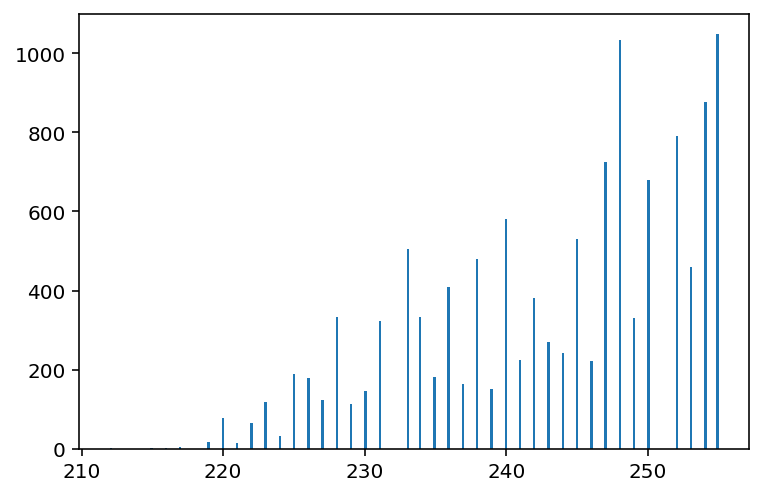

In [27]:
plt.hist(sperg[2].flatten(), bins=256)
